## Leer dataset

In [1]:
import requests
import re
import os
import h5py

In [3]:
path_img = r'TrainData/img/image_5.h5'
mask_img = r'TrainData/mask/mask_5.h5'

In [4]:
with h5py.File(path_img, 'r') as hf_img:
    image = hf_img['img'][:]

with h5py.File(mask_img, 'r') as hf_mask:
    label = hf_mask['mask'][:]

In [9]:
image.shape

(128, 128, 14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


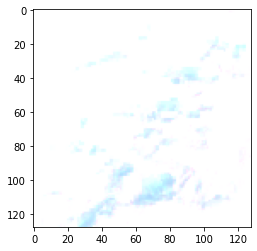

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,[4,3,1]])

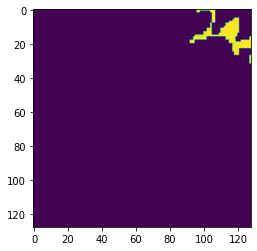

In [6]:
plt.imshow(label)

## Dataloader

In [26]:
import numpy as np
import torch
from torch.utils import data
from torch.utils.data import DataLoader
import h5py

class LandslideDataSet(data.Dataset):
    def __init__(self, data_dir, list_path, max_iters=None, set='labeled'):
        self.list_path = list_path
        self.mean = [-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3000, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
        self.std = [0.9325, 0.8775, 0.8860, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]
        self.set = set
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        
        if not max_iters==None:
            n_repeat = int(np.ceil(max_iters / len(self.img_ids)))
            self.img_ids = self.img_ids * n_repeat + self.img_ids[:max_iters-n_repeat*len(self.img_ids)]

        self.files = []

        if set=='labeled':
            for name in self.img_ids:
                img_file = data_dir + name
                label_file = data_dir + name.replace('img','mask').replace('image','mask')
                self.files.append({
                    'img': img_file,
                    'label': label_file,
                    'name': name
                })
        elif set=='unlabeled':
            for name in self.img_ids:
                img_file = data_dir + name
                self.files.append({
                    'img': img_file,
                    'name': name
                })
            
    def __len__(self):
        return len(self.files)


    def __getitem__(self, index):
        datafiles = self.files[index]
        
        if self.set=='labeled':
            with h5py.File(datafiles['img'], 'r') as hf:
                image = hf['img'][:]
            with h5py.File(datafiles['label'], 'r') as hf:
                label = hf['mask'][:]
            name = datafiles['name']
                
            image = np.asarray(image, np.float32)
            label = np.asarray(label, np.float32)
            image = image.transpose((-1, 0, 1))
            size = image.shape

            for i in range(len(self.mean)):
                image[i,:,:] -= self.mean[i]
                image[i,:,:] /= self.std[i]

            return image.copy(), label.copy(), np.array(size), name

        else:
            with h5py.File(datafiles['img'], 'r') as hf:
                image = hf['img'][:]
            name = datafiles['name']
                
            image = np.asarray(image, np.float32)
            image = image.transpose((-1, 0, 1))
            size = image.shape

            for i in range(len(self.mean)):
                image[i,:,:] -= self.mean[i]
                image[i,:,:] /= self.std[i]

            return image.copy(), np.array(size), name

In [30]:
train_dataset = LandslideDataSet(data_dir=r'', list_path=r'dataset/train.txt') # data_dir='/scratch/Land4Sense_Competition/', 
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, pin_memory=True)

In [31]:
channels_sum,channel_squared_sum = 0,0
num_batches = len(train_loader)
for data,_,_,_ in train_loader:
    channels_sum += torch.mean(data,dim=[0,2,3])   
    channel_squared_sum += torch.mean(data**2,dim=[0,2,3])       

mean = channels_sum/num_batches
std = (channel_squared_sum/num_batches - mean**2)**0.5
print(mean,std) 

tensor([1.5197, 1.4018, 1.2210, 1.1525, 1.1052, 1.1432, 1.1628, 1.1383, 0.9601,
        0.4762, 1.0931, 1.0674, 1.0172, 0.6719]) tensor([0.1512, 0.2515, 0.3594, 0.6454, 0.5195, 0.5304, 0.5567, 0.5828, 0.5665,
        0.4253, 0.6016, 0.7179, 0.7522, 0.8307])
